# 13.3b: Monument Valley Distribution Comparison

**Goal:** Compare how different noise distributions affect Monument Valley black hole demographics.

## The Question

In 13.3a we tested Gaussian noise. But there are many ways to scatter 151,936 tokens around a centroid:

**Distributions to test:**
1. **Gaussian**: ρ(r) ∝ exp(-r²/2σ²) - most points near center, smooth falloff
2. **Uniform Ball**: constant density inside radius R, zero outside - all regions equally populated
3. **Uniform Shell**: all points at exactly radius R - hollow sphere
4. **Laplace**: ρ(r) ∝ exp(-|r|/b) - sharper peak than Gaussian, heavier tails

Different distributions → different bfloat16 cell occupancy → different black hole demographics.

This is a **broad sweep** to identify which distribution(s) are worth studying in detail.

## Parameters

In [1]:
# Input
DEAD_TOKENS_PATH = "../data/tensors/13.1a_dead_tokens.safetensors"

# Monument Valley parameters
N_TOTAL_TOKENS = 151936  # Full vocabulary
N_SURVIVORS = 2221       # Match Qwen's dead token count exactly
N_DIMS = 2560

# Scale parameter sweep (log-spaced between min and max)
SCALE_MIN = 1e-10
SCALE_MAX = 1e-2
N_SCALE_SAMPLES = 10  # Broad sweep, just to see shapes

# Trials per scale (keep low for speed)
N_TRIALS_PER_SCALE = 10

# Distributions to test
DISTRIBUTIONS = ['gaussian', 'uniform_ball', 'uniform_shell', 'laplace']

# Output
OUTPUT_PATH = "../data/tensors/13.3b_distribution_comparison.safetensors"

# Figure settings
DPI = 150

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file, save_file
from tqdm import tqdm

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Check for MPS
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")
print("✓ Imports complete")

Using device: mps
✓ Imports complete


## Generate Scale Values

In [3]:
# Generate log-spaced scale values
SCALE_VALUES = np.logspace(np.log10(SCALE_MIN), np.log10(SCALE_MAX), N_SCALE_SAMPLES).tolist()

print(f"\nScale parameter sweep:")
print(f"  Min: {SCALE_MIN:.2e}")
print(f"  Max: {SCALE_MAX:.2e}")
print(f"  Samples: {N_SCALE_SAMPLES}")
print(f"\nScale values:")
for i, scale in enumerate(SCALE_VALUES):
    print(f"  [{i+1:2d}] {scale:.6e}")


Scale parameter sweep:
  Min: 1.00e-10
  Max: 1.00e-02
  Samples: 10

Scale values:
  [ 1] 1.000000e-10
  [ 2] 7.742637e-10
  [ 3] 5.994843e-09
  [ 4] 4.641589e-08
  [ 5] 3.593814e-07
  [ 6] 2.782559e-06
  [ 7] 2.154435e-05
  [ 8] 1.668101e-04
  [ 9] 1.291550e-03
  [10] 1.000000e-02


## Load Qwen Dead Token Data (for centroid)

In [4]:
print("\nLoading Qwen dead token data...\n")

data = load_file(DEAD_TOKENS_PATH)
qwen_centroid = data['weighted_centroid'].to(device)
qwen_embeddings = data['dead_embeddings_float32']

# Get Qwen's black hole demographics for comparison
qwen_unique, qwen_inverse, qwen_counts = torch.unique(
    qwen_embeddings, dim=0, return_inverse=True, return_counts=True
)
qwen_bh_counts = qwen_counts[qwen_counts >= 2]
qwen_demographics = torch.sort(qwen_bh_counts, descending=True)[0].tolist()

print(f"✓ Loaded centroid: {qwen_centroid.shape}")
print(f"  Centroid norm: {torch.norm(qwen_centroid, p=2).item():.6f}")
print(f"\nQwen demographics (target):")
print(f"  {qwen_demographics}")
print(f"  n_black_holes: {len(qwen_demographics)}")
print(f"  largest_bh: {qwen_demographics[0]}")


Loading Qwen dead token data...

✓ Loaded centroid: torch.Size([2560])
  Centroid norm: 0.370917

Qwen demographics (target):
  [814, 704, 306, 228, 11, 10, 6, 5, 4, 4, 3, 3, 2]
  n_black_holes: 13
  largest_bh: 814


## Distribution Sampling Functions

In [5]:
def sample_gaussian(centroid, scale, n_tokens, n_dims, device):
    """
    Sample from Gaussian(centroid, scale).
    
    Args:
        centroid: center point [n_dims]
        scale: standard deviation (sigma)
        n_tokens: number of samples
        n_dims: dimensionality
        device: torch device
    
    Returns:
        samples [n_tokens, n_dims]
    """
    noise = torch.randn(n_tokens, n_dims, device=device) * scale
    return centroid + noise


def sample_uniform_ball(centroid, scale, n_tokens, n_dims, device):
    """
    Sample uniformly from ball of radius scale.
    
    Args:
        centroid: center point [n_dims]
        scale: radius R
        n_tokens: number of samples
        n_dims: dimensionality
        device: torch device
    
    Returns:
        samples [n_tokens, n_dims]
    """
    # Random directions (uniform on sphere)
    directions = torch.randn(n_tokens, n_dims, device=device)
    directions = directions / torch.norm(directions, dim=1, keepdim=True)
    
    # Random radii (uniform in volume)
    # For uniform density in n-dims, r ~ U(0,1)^(1/n)
    radii = torch.rand(n_tokens, device=device).pow(1.0 / n_dims) * scale
    
    return centroid + directions * radii.unsqueeze(1)


def sample_uniform_shell(centroid, scale, n_tokens, n_dims, device):
    """
    Sample uniformly from shell at radius scale.
    
    Args:
        centroid: center point [n_dims]
        scale: radius R
        n_tokens: number of samples
        n_dims: dimensionality
        device: torch device
    
    Returns:
        samples [n_tokens, n_dims]
    """
    # Random directions (uniform on sphere)
    directions = torch.randn(n_tokens, n_dims, device=device)
    directions = directions / torch.norm(directions, dim=1, keepdim=True)
    
    # All at exactly radius scale
    return centroid + directions * scale


def sample_laplace(centroid, scale, n_tokens, n_dims, device):
    """
    Sample from Laplace distribution with scale parameter b.
    
    Laplace(0, b) has PDF: (1/2b) exp(-|x|/b)
    
    We'll use component-wise Laplace for simplicity.
    
    Args:
        centroid: center point [n_dims]
        scale: scale parameter b
        n_tokens: number of samples
        n_dims: dimensionality
        device: torch device
    
    Returns:
        samples [n_tokens, n_dims]
    """
    # PyTorch doesn't have Laplace, use transformation from uniform
    # Laplace: X = -b*sign(U)*log(1-2|U|) where U ~ Uniform(-0.5, 0.5)
    u = torch.rand(n_tokens, n_dims, device=device) - 0.5  # U(-0.5, 0.5)
    noise = -scale * torch.sign(u) * torch.log(1 - 2 * torch.abs(u))
    
    return centroid + noise


# Dispatch dictionary
SAMPLERS = {
    'gaussian': sample_gaussian,
    'uniform_ball': sample_uniform_ball,
    'uniform_shell': sample_uniform_shell,
    'laplace': sample_laplace,
}

print("✓ Defined distribution samplers")
print(f"  Available: {list(SAMPLERS.keys())}")

✓ Defined distribution samplers
  Available: ['gaussian', 'uniform_ball', 'uniform_shell', 'laplace']


## Monument Valley Simulation Function

In [6]:
def run_monument_valley_trial(distribution, scale, centroid):
    """
    Run one Monument Valley trial with given distribution and scale.
    
    Args:
        distribution: name of distribution ('gaussian', 'uniform_ball', etc.)
        scale: scale parameter
        centroid: center point for initialization (on MPS)
    
    Returns:
        dict with statistics
    """
    # 1. Sample from distribution on MPS
    sampler = SAMPLERS[distribution]
    init_f32 = sampler(centroid, scale, N_TOTAL_TOKENS, N_DIMS, device)
    
    # 2. Quantize to bfloat16 (on MPS)
    init_bf16 = init_f32.to(torch.bfloat16)
    
    # 3. Uniformly sample N_SURVIVORS indices
    survivor_indices = torch.randperm(N_TOTAL_TOKENS, device=device)[:N_SURVIVORS]
    survivors = init_bf16[survivor_indices]  # [N_SURVIVORS, N_DIMS]
    
    # 4. Move to CPU for unique processing
    survivors_cpu = survivors.to('cpu', dtype=torch.float32)
    
    # 5. Get unique vectors and demographics
    unique, inverse, counts = torch.unique(
        survivors_cpu, dim=0, return_inverse=True, return_counts=True
    )
    
    n_unique = len(unique)
    n_singletons = (counts == 1).sum().item()
    
    # Black hole demographics
    bh_mask = counts >= 2
    bh_counts = counts[bh_mask]
    
    if len(bh_counts) > 0:
        sorted_bh_counts = torch.sort(bh_counts, descending=True)[0]
        n_black_holes = len(sorted_bh_counts)
        largest_bh = sorted_bh_counts[0].item()
    else:
        n_black_holes = 0
        largest_bh = 0
    
    return {
        'n_unique': n_unique,
        'n_singletons': n_singletons,
        'n_black_holes': n_black_holes,
        'largest_bh': largest_bh,
    }

print("✓ Defined Monument Valley trial function")

✓ Defined Monument Valley trial function


## Run Distribution Comparison

In [7]:
print(f"\nRunning distribution comparison...\n")
print(f"Parameters:")
print(f"  Total tokens: {N_TOTAL_TOKENS:,}")
print(f"  Survivors: {N_SURVIVORS:,}")
print(f"  Distributions: {len(DISTRIBUTIONS)}")
print(f"  Scale values: {len(SCALE_VALUES)}")
print(f"  Trials per (distribution, scale): {N_TRIALS_PER_SCALE}\n")

# Storage for results
# all_results[distribution][scale] = list of trial results
all_results = {dist: {} for dist in DISTRIBUTIONS}

# Sweep over distributions and scales
for distribution in tqdm(DISTRIBUTIONS, desc="Distributions"):
    for scale in tqdm(SCALE_VALUES, desc=f"{distribution}", leave=False):
        scale_results = []
        
        # Run trials
        for trial_idx in range(N_TRIALS_PER_SCALE):
            result = run_monument_valley_trial(
                distribution=distribution,
                scale=scale,
                centroid=qwen_centroid
            )
            scale_results.append(result)
        
        all_results[distribution][scale] = scale_results

print(f"\n✓ Completed {len(DISTRIBUTIONS)} distributions × {len(SCALE_VALUES)} scales × {N_TRIALS_PER_SCALE} trials")


Running distribution comparison...

Parameters:
  Total tokens: 151,936
  Survivors: 2,221
  Distributions: 4
  Scale values: 10
  Trials per (distribution, scale): 10



Distributions: 100%|██████████| 4/4 [00:51<00:00, 12.78s/it]


✓ Completed 4 distributions × 10 scales × 10 trials


## Aggregate Statistics Per Distribution

In [8]:
print("\nAggregating statistics...\n")

# summary_stats[distribution] = list of stats dicts (one per scale)
summary_stats = {dist: [] for dist in DISTRIBUTIONS}

for distribution in DISTRIBUTIONS:
    for scale in SCALE_VALUES:
        results = all_results[distribution][scale]
        
        # Extract arrays
        n_unique_arr = np.array([r['n_unique'] for r in results])
        n_singletons_arr = np.array([r['n_singletons'] for r in results])
        n_black_holes_arr = np.array([r['n_black_holes'] for r in results])
        largest_bh_arr = np.array([r['largest_bh'] for r in results])
        
        # Compute summary
        summary = {
            'scale': scale,
            'n_unique_mean': n_unique_arr.mean(),
            'n_unique_std': n_unique_arr.std(),
            'n_singletons_mean': n_singletons_arr.mean(),
            'n_singletons_std': n_singletons_arr.std(),
            'n_black_holes_mean': n_black_holes_arr.mean(),
            'n_black_holes_std': n_black_holes_arr.std(),
            'largest_bh_mean': largest_bh_arr.mean(),
            'largest_bh_std': largest_bh_arr.std(),
        }
        
        summary_stats[distribution].append(summary)

print(f"✓ Aggregated statistics for {len(DISTRIBUTIONS)} distributions")


Aggregating statistics...

✓ Aggregated statistics for 4 distributions


## Figure 1: Black Hole Count Comparison

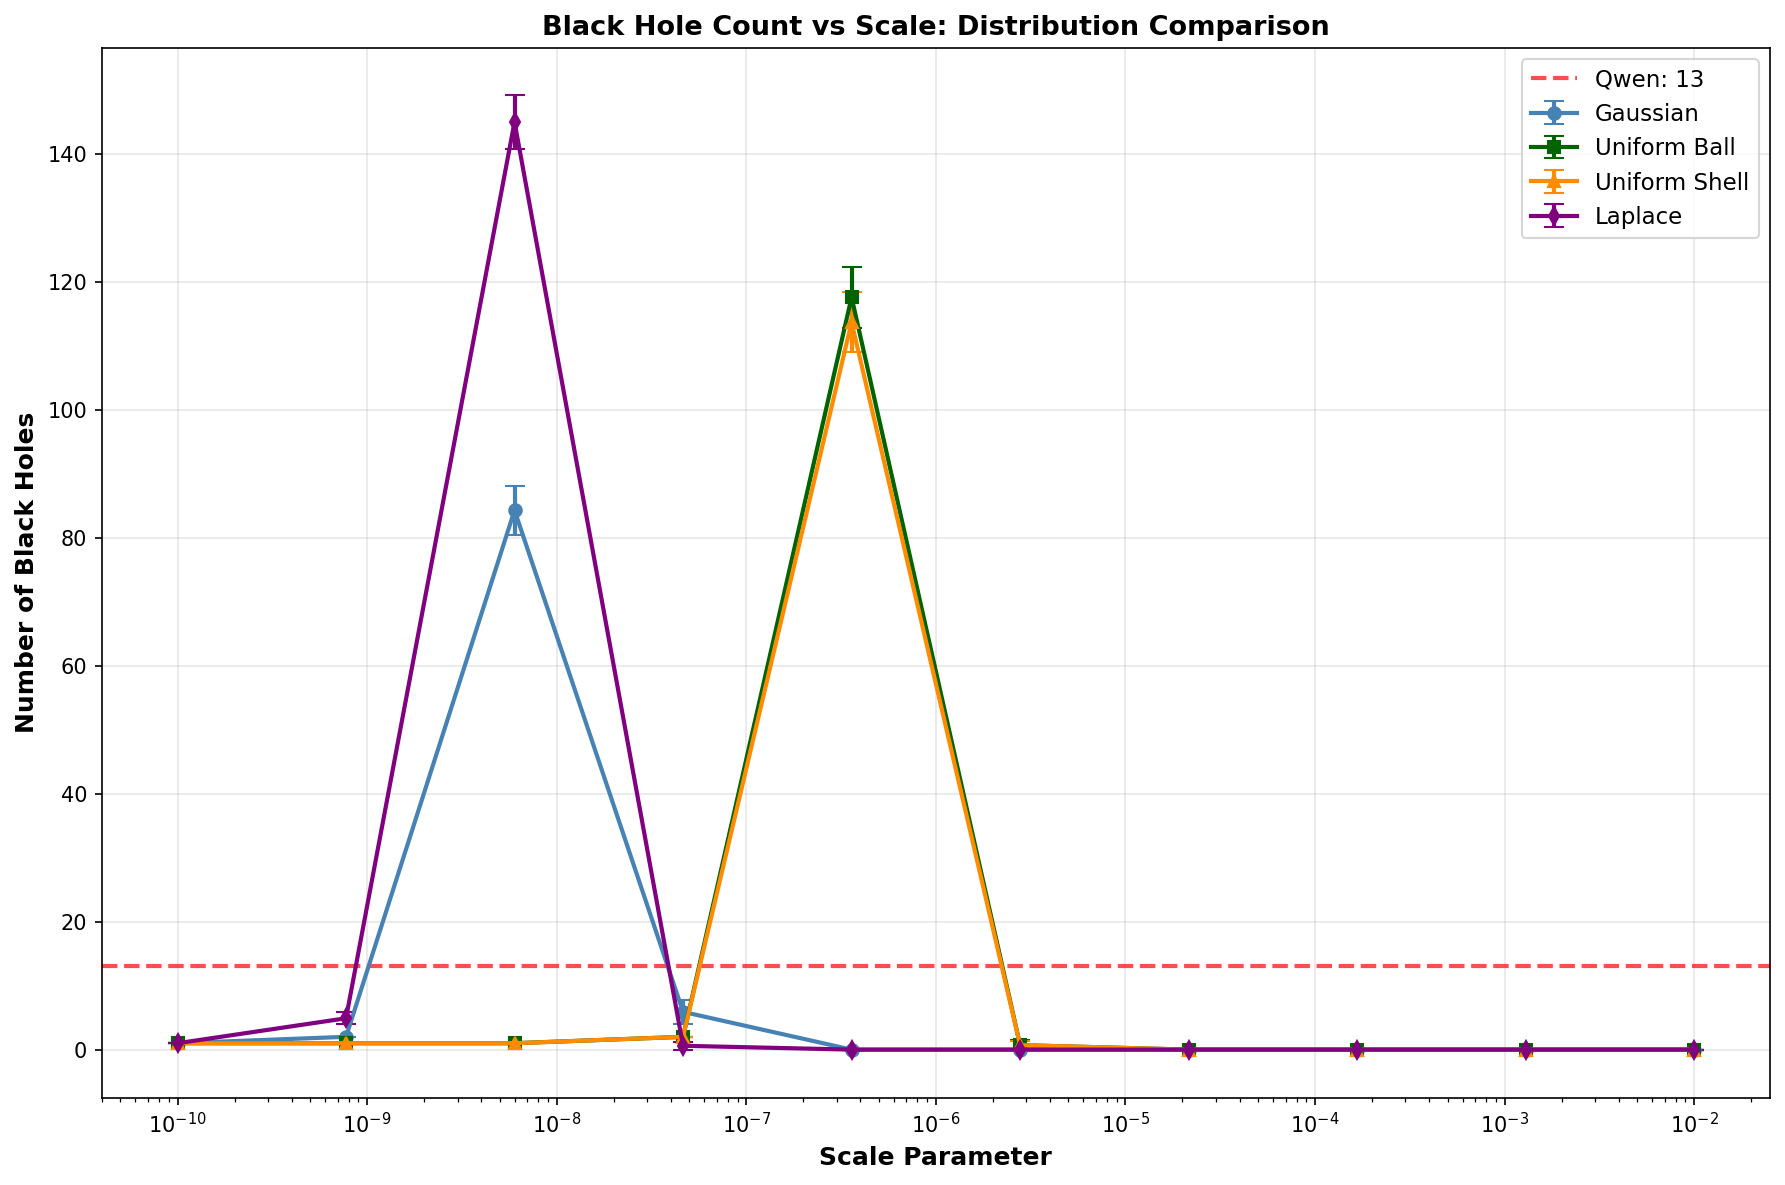

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=DPI)

# Plot each distribution
colors = ['steelblue', 'darkgreen', 'darkorange', 'purple']
markers = ['o', 's', '^', 'd']

for i, distribution in enumerate(DISTRIBUTIONS):
    stats = summary_stats[distribution]
    scales = [s['scale'] for s in stats]
    n_bh_means = [s['n_black_holes_mean'] for s in stats]
    n_bh_stds = [s['n_black_holes_std'] for s in stats]
    
    ax.errorbar(scales, n_bh_means, yerr=n_bh_stds, 
                marker=markers[i], linestyle='-', capsize=5, 
                color=colors[i], label=distribution.replace('_', ' ').title(),
                linewidth=2, markersize=6)

# Qwen target
ax.axhline(len(qwen_demographics), color='red', linestyle='--', 
           linewidth=2, alpha=0.7, label=f'Qwen: {len(qwen_demographics)}')

ax.set_xlabel('Scale Parameter', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Black Holes', fontsize=12, fontweight='bold')
ax.set_title('Black Hole Count vs Scale: Distribution Comparison', 
             fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Figure 2: Largest Black Hole Size Comparison

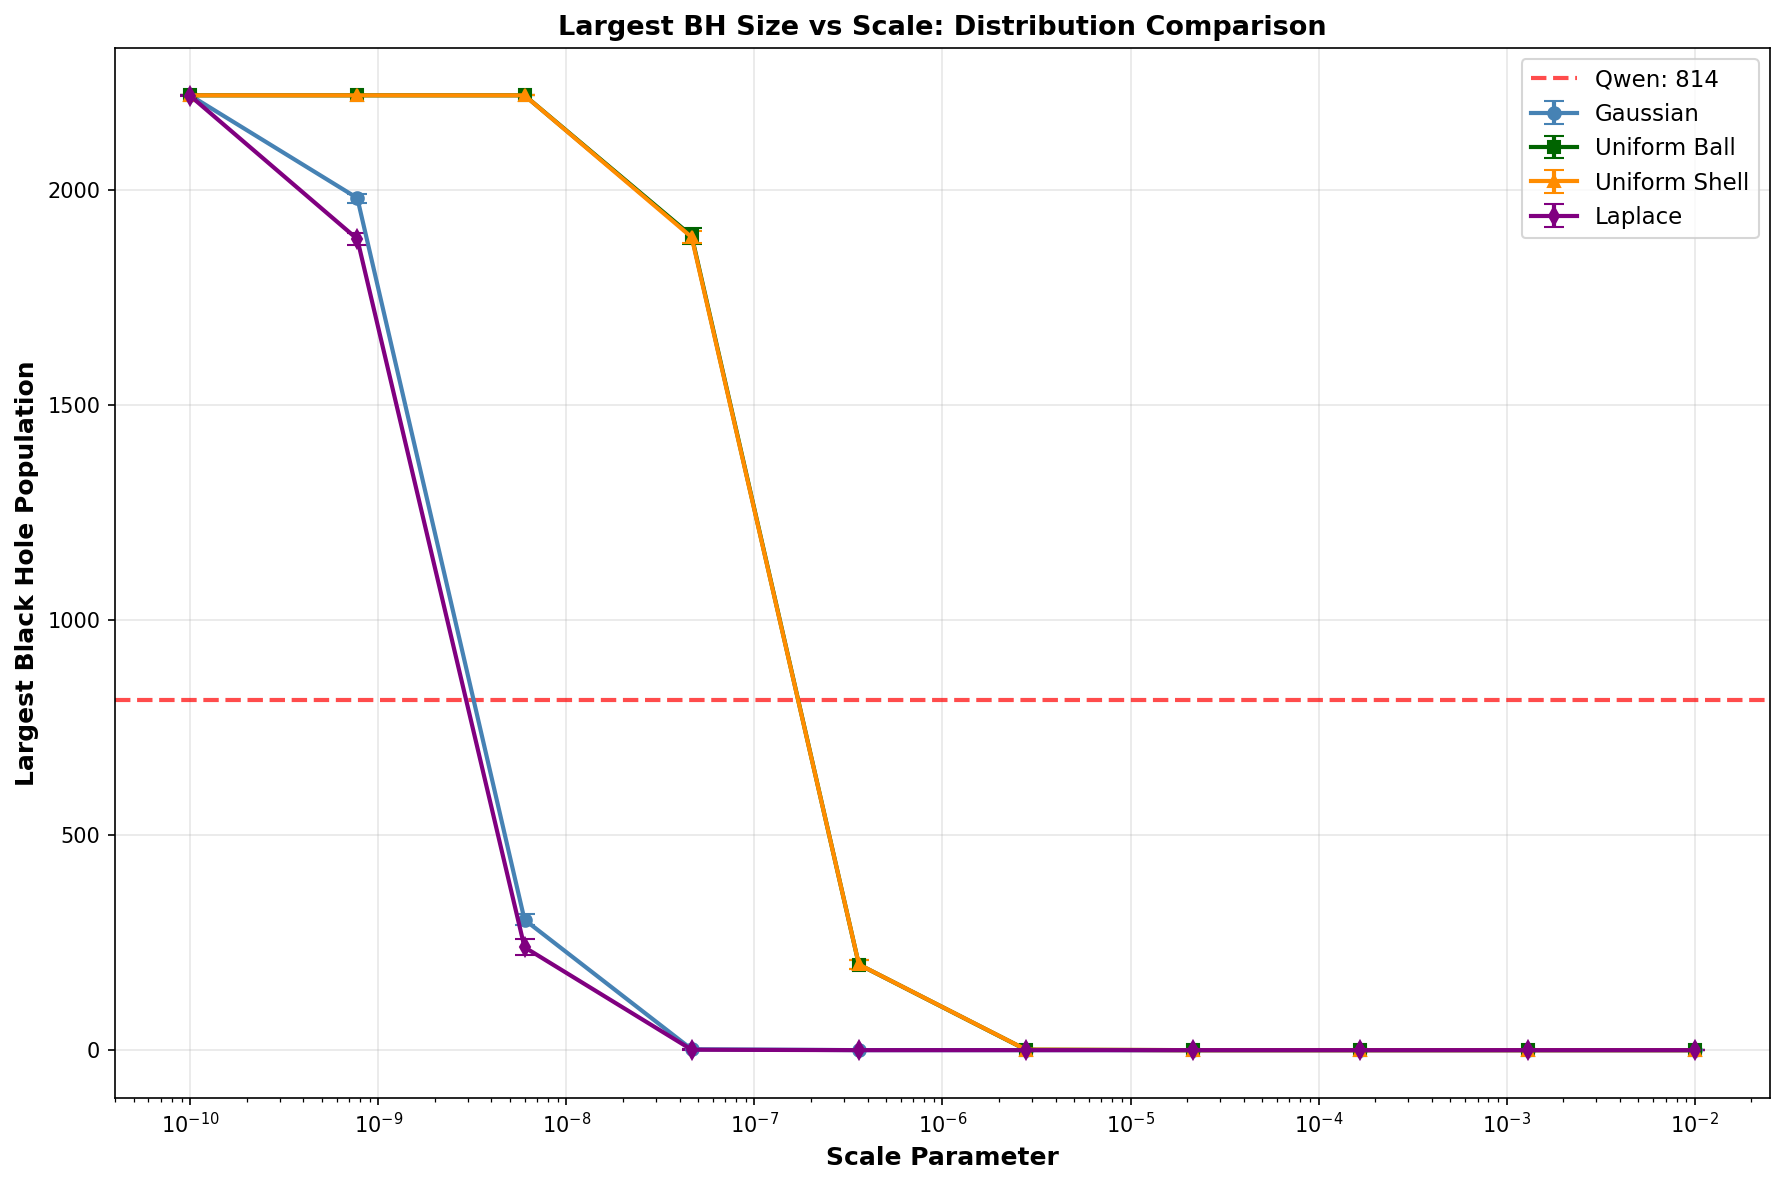

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=DPI)

# Plot each distribution
for i, distribution in enumerate(DISTRIBUTIONS):
    stats = summary_stats[distribution]
    scales = [s['scale'] for s in stats]
    largest_means = [s['largest_bh_mean'] for s in stats]
    largest_stds = [s['largest_bh_std'] for s in stats]
    
    ax.errorbar(scales, largest_means, yerr=largest_stds, 
                marker=markers[i], linestyle='-', capsize=5, 
                color=colors[i], label=distribution.replace('_', ' ').title(),
                linewidth=2, markersize=6)

# Qwen target
ax.axhline(qwen_demographics[0], color='red', linestyle='--', 
           linewidth=2, alpha=0.7, label=f'Qwen: {qwen_demographics[0]}')

ax.set_xlabel('Scale Parameter', fontsize=12, fontweight='bold')
ax.set_ylabel('Largest Black Hole Population', fontsize=12, fontweight='bold')
ax.set_title('Largest BH Size vs Scale: Distribution Comparison', 
             fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Figure 3: 4-Panel Summary

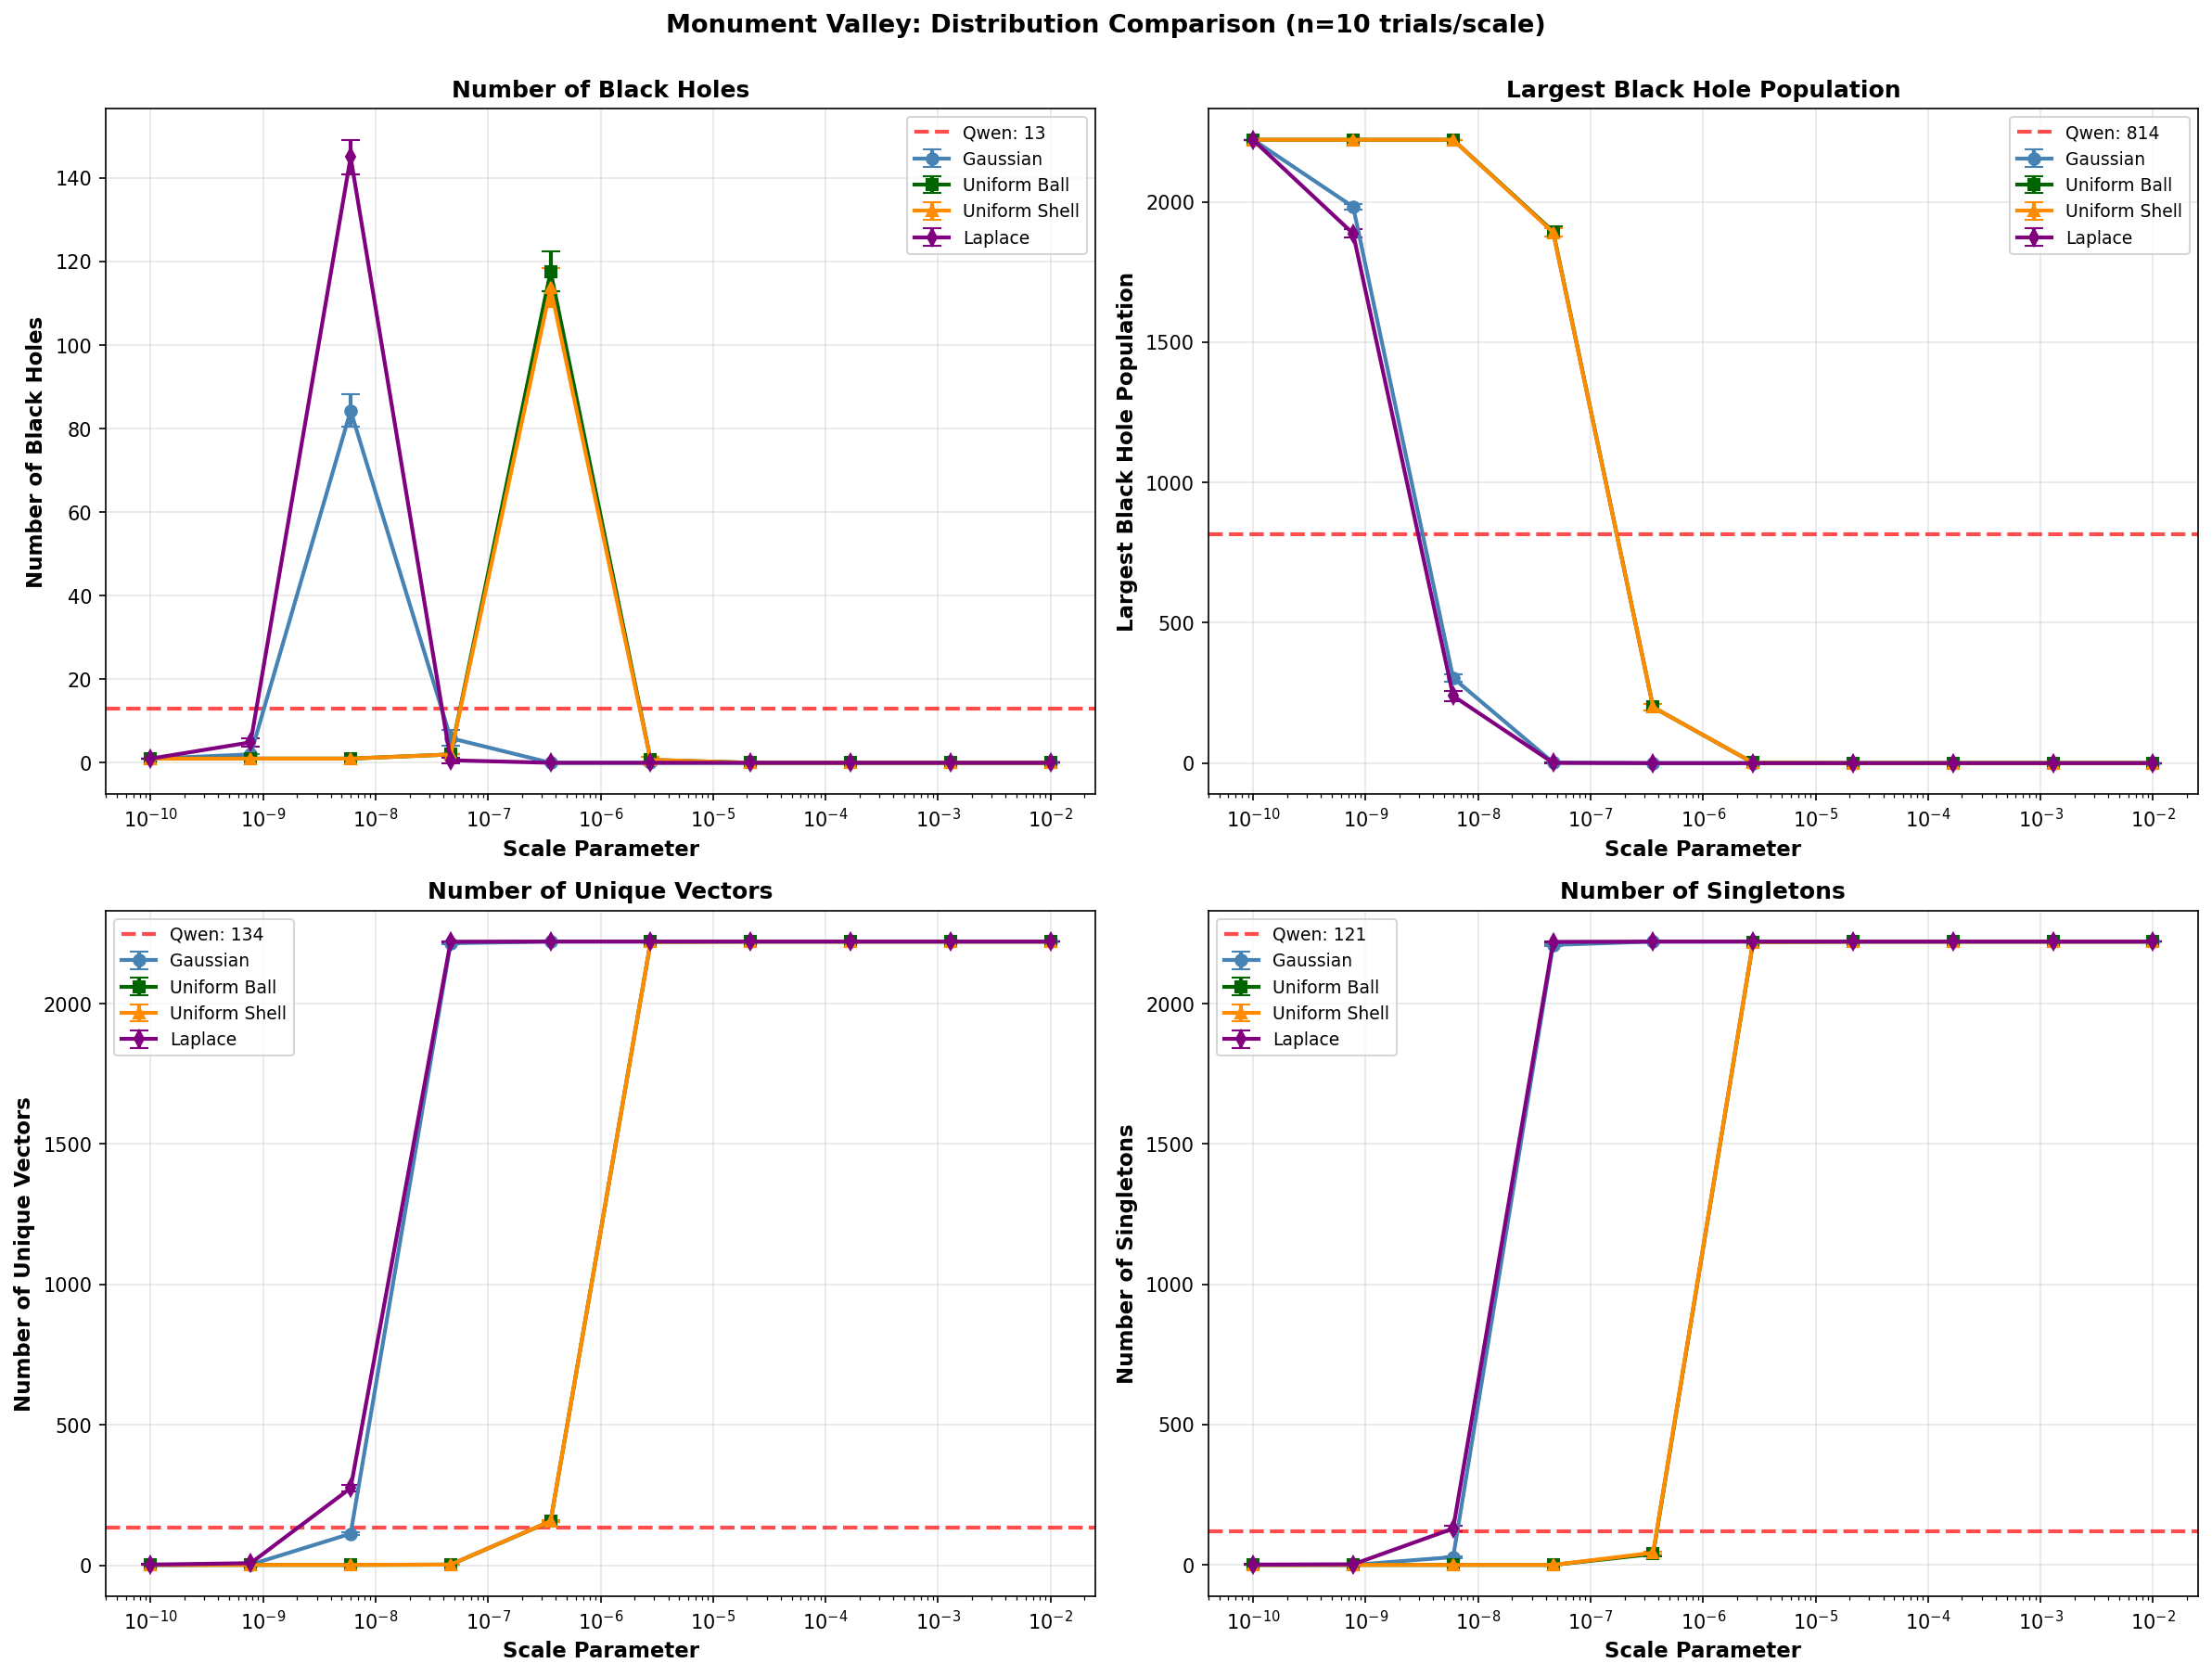

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=DPI)

metrics = [
    ('n_black_holes_mean', 'n_black_holes_std', 'Number of Black Holes', len(qwen_demographics)),
    ('largest_bh_mean', 'largest_bh_std', 'Largest Black Hole Population', qwen_demographics[0]),
    ('n_unique_mean', 'n_unique_std', 'Number of Unique Vectors', 134),
    ('n_singletons_mean', 'n_singletons_std', 'Number of Singletons', 121),
]

for idx, (mean_key, std_key, ylabel, qwen_target) in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    # Plot each distribution
    for i, distribution in enumerate(DISTRIBUTIONS):
        stats = summary_stats[distribution]
        scales = [s['scale'] for s in stats]
        means = [s[mean_key] for s in stats]
        stds = [s[std_key] for s in stats]
        
        ax.errorbar(scales, means, yerr=stds, 
                    marker=markers[i], linestyle='-', capsize=5, 
                    color=colors[i], label=distribution.replace('_', ' ').title(),
                    linewidth=2, markersize=6)
    
    # Qwen target
    ax.axhline(qwen_target, color='red', linestyle='--', 
               linewidth=2, alpha=0.7, label=f'Qwen: {qwen_target}')
    
    ax.set_xlabel('Scale Parameter', fontsize=11, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=11, fontweight='bold')
    ax.set_title(ylabel, fontsize=12, fontweight='bold')
    ax.set_xscale('log')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Monument Valley: Distribution Comparison (n={N_TRIALS_PER_SCALE} trials/scale)',
             fontsize=13, fontweight='bold', y=1.00)

plt.tight_layout()
plt.show()

## Summary Table

In [12]:
print(f"\n{'='*120}")
print(f"DISTRIBUTION COMPARISON SUMMARY")
print(f"{'='*120}\n")

print(f"Qwen targets:")
print(f"  n_black_holes: {len(qwen_demographics)}")
print(f"  largest_bh: {qwen_demographics[0]}")
print(f"  n_unique: 134")
print(f"  n_singletons: 121\n")

for distribution in DISTRIBUTIONS:
    print(f"\n{distribution.upper().replace('_', ' ')}:")
    print(f"{'Scale':>15} {'n_BH':>8} {'largest_BH':>12} {'n_unique':>10} {'n_single':>10}")
    print("-" * 60)
    
    stats = summary_stats[distribution]
    for s in stats:
        scale = s['scale']
        n_bh = s['n_black_holes_mean']
        largest = s['largest_bh_mean']
        n_unique = s['n_unique_mean']
        n_single = s['n_singletons_mean']
        
        print(f"{scale:>15.6e} {n_bh:>5.1f} {largest:>6.0f} {n_unique:>7.1f} {n_single:>7.1f}")

print(f"\n{'='*120}")


DISTRIBUTION COMPARISON SUMMARY

Qwen targets:
  n_black_holes: 13
  largest_bh: 814
  n_unique: 134
  n_singletons: 121


GAUSSIAN:
          Scale     n_BH   largest_BH   n_unique   n_single
------------------------------------------------------------
   1.000000e-10   1.0   2221     1.0     0.0
   7.742637e-10   2.0   1982     2.1     0.1
   5.994843e-09  84.3    303   112.1    27.8
   4.641589e-08   5.9      2  2215.1  2209.2
   3.593814e-07   0.0      0  2221.0  2221.0
   2.782559e-06   0.0      0  2221.0  2221.0
   2.154435e-05   0.0      0  2221.0  2221.0
   1.668101e-04   0.0      0  2221.0  2221.0
   1.291550e-03   0.0      0  2221.0  2221.0
   1.000000e-02   0.0      0  2221.0  2221.0

UNIFORM BALL:
          Scale     n_BH   largest_BH   n_unique   n_single
------------------------------------------------------------
   1.000000e-10   1.0   2221     1.0     0.0
   7.742637e-10   1.0   2221     1.0     0.0
   5.994843e-09   1.0   2221     1.0     0.0
   4.641589e-08   2.0   

## Save Results

In [13]:
print("\nSaving results...\n")

# Prepare tensors for saving
save_dict = {
    'scale_min': torch.tensor(SCALE_MIN, dtype=torch.float32),
    'scale_max': torch.tensor(SCALE_MAX, dtype=torch.float32),
    'n_scale_samples': torch.tensor(N_SCALE_SAMPLES, dtype=torch.int64),
    'scale_values': torch.tensor(SCALE_VALUES, dtype=torch.float32),
    'n_trials_per_scale': torch.tensor(N_TRIALS_PER_SCALE, dtype=torch.int64),
}

# Add per-distribution statistics
for distribution in DISTRIBUTIONS:
    stats = summary_stats[distribution]
    prefix = distribution
    
    save_dict[f'{prefix}_n_black_holes_mean'] = torch.tensor(
        [s['n_black_holes_mean'] for s in stats], dtype=torch.float32)
    save_dict[f'{prefix}_n_black_holes_std'] = torch.tensor(
        [s['n_black_holes_std'] for s in stats], dtype=torch.float32)
    save_dict[f'{prefix}_largest_bh_mean'] = torch.tensor(
        [s['largest_bh_mean'] for s in stats], dtype=torch.float32)
    save_dict[f'{prefix}_largest_bh_std'] = torch.tensor(
        [s['largest_bh_std'] for s in stats], dtype=torch.float32)
    save_dict[f'{prefix}_n_unique_mean'] = torch.tensor(
        [s['n_unique_mean'] for s in stats], dtype=torch.float32)
    save_dict[f'{prefix}_n_singletons_mean'] = torch.tensor(
        [s['n_singletons_mean'] for s in stats], dtype=torch.float32)

save_file(save_dict, OUTPUT_PATH)

print(f"✓ Saved to {OUTPUT_PATH}")
print(f"\nSaved {len(save_dict)} tensors")


Saving results...

✓ Saved to ../data/tensors/13.3b_distribution_comparison.safetensors

Saved 29 tensors


## Summary

In [14]:
print(f"\n{'='*120}")
print(f"DISTRIBUTION COMPARISON COMPLETE")
print(f"{'='*120}")
print(f"\nDistributions tested:")
for distribution in DISTRIBUTIONS:
    print(f"  - {distribution.replace('_', ' ').title()}")
print(f"\nScale sweep:")
print(f"  Range: {SCALE_MIN:.2e} to {SCALE_MAX:.2e}")
print(f"  Samples: {N_SCALE_SAMPLES} (log-spaced)")
print(f"  Trials per scale: {N_TRIALS_PER_SCALE}")
print(f"  Total trials: {len(DISTRIBUTIONS) * len(SCALE_VALUES) * N_TRIALS_PER_SCALE:,}")
print(f"\nNext steps:")
print(f"  - Examine plots to identify which distribution(s) come closest to Qwen")
print(f"  - Note the scale range where interesting behavior occurs")
print(f"  - Use 13.3c to do deep dive with chosen distribution + narrow scale range")
print(f"\n{'='*120}")


DISTRIBUTION COMPARISON COMPLETE

Distributions tested:
  - Gaussian
  - Uniform Ball
  - Uniform Shell
  - Laplace

Scale sweep:
  Range: 1.00e-10 to 1.00e-02
  Samples: 10 (log-spaced)
  Trials per scale: 10
  Total trials: 400

Next steps:
  - Examine plots to identify which distribution(s) come closest to Qwen
  - Note the scale range where interesting behavior occurs
  - Use 13.3c to do deep dive with chosen distribution + narrow scale range

